# Step 1.3: Feature Engineering
## LinkedIn Engagement Prediction - TrendPilot

**Date:** February 1, 2026  
**Objective:** Extract comprehensive features from preprocessed content for ML modeling

---

## Overview

This notebook extracts **80-100 features** across four major categories:

1. **Base Formula Features (25-30):** Implement algorithmic scoring logic as ML features
2. **NLP Features (40-50):** Sentiment, entities, readability, embeddings
3. **Topic Features (5-10):** Topic modeling labels and scores
4. **Derived Features (10-20):** Influencer stats, engagement ratios, interactions

**Why Feature Engineering Matters:**
- Machine learning models learn from features, not raw text
- Base formula captures domain expertise (viral patterns, LinkedIn penalties)
- NLP features capture semantic meaning (sentiment, topics, complexity)
- Derived features capture context (influencer history, follower ratios)

**Feature Engineering Principles:**
- **Explainability:** Every feature should have clear business meaning
- **Orthogonality:** Minimize redundancy (handle in feature selection step)
- **Scalability:** Features should generalize to new posts
- **Domain Knowledge:** Leverage LinkedIn engagement patterns from base formula

---

## 1. Setup and Imports

In [53]:
# Standard libraries
import numpy as np
import pandas as pd

import re
import json
from collections import Counter
import warnings
warnings.filterwarnings('ignore')



In [54]:
# NLP libraries
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import spacy

# Readability
import textstat

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 100)
sns.set_style('whitegrid')

print("✓ Libraries imported successfully")
print(f"Pandas version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")

✓ Libraries imported successfully
Pandas version: 3.0.1
NumPy version: 2.3.5


## 2. Download Required NLP Resources

In [55]:
# Download NLTK data (run once)
try:
    nltk.data.find('tokenizers/punkt')
    print("✓ NLTK punkt already downloaded")
except LookupError:
    print("Downloading NLTK punkt...")
    nltk.download('punkt', quiet=True)

try:
    nltk.data.find('corpora/stopwords')
    print("✓ NLTK stopwords already downloaded")
except LookupError:
    print("Downloading NLTK stopwords...")
    nltk.download('stopwords', quiet=True)

try:
    nltk.data.find('sentiment/vader_lexicon')
    print("✓ VADER lexicon already downloaded")
except LookupError:
    print("Downloading VADER lexicon...")
    nltk.download('vader_lexicon', quiet=True)

# Load spaCy model - simplified version
print("Loading spaCy model...")
import subprocess
import sys

try:
    nlp = spacy.load('en_core_web_sm')
    print("✓ spaCy model loaded")
except OSError:
    print("Downloading spaCy model (this may take a minute)...")
    subprocess.check_call([sys.executable, "-m", "spacy", "download", "en_core_web_sm"])
    nlp = spacy.load('en_core_web_sm')
    print("✓ spaCy model downloaded and loaded")

print("\n✓ All NLP resources ready")

✓ NLTK punkt already downloaded
✓ NLTK stopwords already downloaded
Loading spaCy model...
✓ spaCy model loaded

✓ All NLP resources ready


## 3. Load Preprocessed Data

In [56]:
# Define file paths
INPUT_FILE = '../data/preprocessed_data.csv'
OUTPUT_FILE = '../data/feature_engineered_data.csv'
FEATURE_METADATA_FILE = '../data/feature_metadata.json'

# Load data
df = pd.read_csv(INPUT_FILE)

print(f"Dataset loaded: {df.shape[0]:,} rows × {df.shape[1]} columns")
print(f"\nColumns: {list(df.columns)}")
print(f"\nMemory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
df.head(3)

Dataset loaded: 606 rows × 28 columns

Columns: ['name', 'content', 'reactions', 'comments', 'time_spent', 'location', 'followers', 'media_type', 'num_hashtags', 'url_count', 'has_external_link', 'urls_list', 'mention_count', 'mentions_list', 'emoji_count', 'unique_emoji_count', 'emojis_list', 'hashtag_count_extracted', 'hashtags_list', 'char_count_original', 'char_count_clean', 'word_count_original', 'word_count_clean', 'sentence_count', 'question_mark_count', 'exclamation_mark_count', 'line_break_count', 'clean_content']

Memory usage: 4.08 MB


,name,content,reactions,comments,time_spent,location,followers,media_type,num_hashtags,url_count,has_external_link,urls_list,mention_count,mentions_list,emoji_count,unique_emoji_count,emojis_list,hashtag_count_extracted,hashtags_list,char_count_original,char_count_clean,word_count_original,word_count_clean,sentence_count,question_mark_count,exclamation_mark_count,line_break_count,clean_content
0,kevinswiber,"I’m not famous. I’m not even popular. But I have mentored people from hobbyists to founders, fro...",65,8,5,NaN,3690,post,0,0,0,[],0,[],0,0,[],0,[],189,186,35,35,5,0,0,0,"im not famous. im not even popular. but i have mentored people from hobbyists to founders, from ..."
1,puneet-bhardwaj-849aa01,AI at the speed of light! While researching the most recent advances in edge computing I came ac...,34,2,3,NaN,2546,post,4,1,1,['https://lnkd.in/g8eTMBQu'],0,[],1,1,['️'],4,"['#EdgeComputing', '#MIT', '#Innovation', '#FutureOfTech']",1519,1491,238,236,20,1,1,0,ai at the speed of light! while researching the most recent advances in edge computing i came ac...
2,jainnitin1983,I wanted to share that I’ve decided to move on from Kinetix . It’s been an incredibly rewarding ...,34,5,1,NaN,3888,post,0,0,0,[],0,[],0,0,[],0,[],452,448,76,76,6,0,0,0,i wanted to share that ive decided to move on from kinetix . its been an incredibly rewarding jo...


## 4. Base Formula Features Implementation

### 4.1 Content Length Scoring

**From base_score_calculation.txt:**
- 100-200 words: +8 (optimal)
- 80-99 words: +5 (good)
- 200-300 words: +3 (acceptable)
- 50-79 words: -3 (short)
- <50 words: -12 (too short)
- >300 words: -15 (too long)

**Why This Matters:**
- LinkedIn algorithm favors moderate-length posts (attention span)
- Too short = lacks substance
- Too long = loses reader attention
- 100-200 words is the "sweet spot" per base formula analysis

In [57]:
def calculate_length_score(word_count):
    """
    Calculate content length score based on base formula.
    
    Args:
        word_count (int): Number of words in clean content
    
    Returns:
        int: Length score (-15 to +8)
    """
    if pd.isna(word_count):
        return -12  # Treat missing as too short
    
    if 100 <= word_count <= 200:
        return 8  # Optimal
    elif 80 <= word_count < 100:
        return 5  # Good
    elif 200 < word_count <= 300:
        return 3  # Acceptable
    elif 50 <= word_count < 80:
        return -3  # Short
    elif word_count < 50:
        return -12  # Too short
    else:  # >300
        return -15  # Too long

def categorize_length(word_count):
    """
    Categorize post length for analysis.
    """
    if pd.isna(word_count) or word_count < 50:
        return 'too_short'
    elif 50 <= word_count < 80:
        return 'short'
    elif 80 <= word_count < 100:
        return 'good'
    elif 100 <= word_count <= 200:
        return 'optimal'
    elif 200 < word_count <= 300:
        return 'acceptable'
    else:
        return 'too_long'

# Apply length scoring
df['length_score'] = df['word_count_clean'].apply(calculate_length_score)
df['length_category'] = df['word_count_clean'].apply(categorize_length)

print("✓ Content length features created")
print(f"\nLength category distribution:")
print(df['length_category'].value_counts())
print(f"\nLength score statistics:")
print(df['length_score'].describe())

✓ Content length features created

Length category distribution:
length_category
optimal       176
too_long      153
acceptable     91
too_short      84
short          62
good           40
Name: count, dtype: int64

Length score statistics:
count    606.000000
mean      -2.653465
std        9.611910
min      -15.000000
25%      -15.000000
50%        3.000000
75%        8.000000
max        8.000000
Name: length_score, dtype: float64


### 4.2 Hook Pattern Detection (First Sentence)

**From base_score_calculation.txt:**
Hook patterns are attention-grabbing openings that increase engagement.
Only the first matching hook counts.

**Why Hooks Matter:**
- First sentence determines if user keeps reading
- Specific patterns trigger psychological responses
- "Never" narrative = overcoming adversity (inspiring)
- Specific time = urgency/immediacy ("It's 2:47am...")
- Contrarian takes = intellectual curiosity ("Stop doing X")

**Implementation Strategy:**
- Extract first sentence from clean_content
- Check patterns in priority order (per base formula)
- Return first match (avoid double-counting)

In [58]:
def extract_first_sentence(text):
    """
    Extract first sentence from text.
    Uses period, exclamation, or question mark as delimiter.
    """
    if pd.isna(text) or text == "":
        return ""
    
    # Split on sentence-ending punctuation
    sentences = re.split(r'[.!?]+', str(text))
    if sentences:
        return sentences[0].strip().lower()
    return ""

def detect_hook_pattern(first_sentence):
    """
    Detect hook pattern in first sentence.
    Returns tuple: (hook_type, hook_score)
    
    Priority order matches base formula:
    1. Never narrative (+15)
    2. Specific time (+12)
    3. Quote hook (+10)
    4. Contrarian (+7)
    5. I used to think/believe (+6)
    6. It's official/Today (+6)
    7. Everyone's/Everyone is (+5)
    8. Just realized (+5)
    9. Recency signals (+4)
    """
    if not first_sentence:
        return 'no_hook', 0
    
    sentence = first_sentence.lower()
    
    # 1. Never narrative (overcoming doubt)
    if re.search(r'\bnever\b.*\b(thought|believed|imagined|expected)', sentence):
        return 'never_narrative', 15
    
    # 2. Specific time (urgency)
    if re.search(r'\b\d{1,2}:\d{2}\s*(am|pm)?\b', sentence):
        return 'specific_time', 12
    
    # 3. Quote hook
    if sentence.startswith('"') or sentence.startswith("'"):
        return 'quote_hook', 10
    
    # 4. Contrarian (Stop/Start)
    if re.search(r'\b(stop|start|quit|avoid|never)\s+(doing|using|saying|thinking)', sentence):
        return 'contrarian', 7
    
    # 5. Belief transformation
    if re.search(r'\bi\s+used\s+to\s+(think|believe|assume)', sentence):
        return 'belief_transformation', 6
    
    # 6. Official/Today announcement
    if re.search(r"\b(it's official|today|finally|announcing)\b", sentence):
        return 'announcement', 6
    
    # 7. Everyone pattern
    if re.search(r"\beveryone('s| is)\b", sentence):
        return 'everyone_pattern', 5
    
    # 8. Just realized
    if re.search(r'\bjust\s+(realized|learned|discovered|noticed)', sentence):
        return 'realization', 5
    
    # 9. Recency signals
    if re.search(r'\b(hours? ago|last (week|month)|yesterday|recently)\b', sentence):
        return 'recency', 4
    
    return 'no_hook', 0

# Extract first sentences
print("Extracting first sentences...")
df['first_sentence'] = df['clean_content'].apply(extract_first_sentence)

# Detect hook patterns
print("Detecting hook patterns...")
df[['hook_type', 'hook_score']] = df['first_sentence'].apply(
    lambda x: pd.Series(detect_hook_pattern(x))
)

# Create binary indicators for each hook type
hook_types = ['never_narrative', 'specific_time', 'quote_hook', 'contrarian', 
              'belief_transformation', 'announcement', 'everyone_pattern', 
              'realization', 'recency']

for hook in hook_types:
    df[f'has_{hook}_hook'] = (df['hook_type'] == hook).astype(int)

print("✓ Hook pattern features created")
print(f"\nHook type distribution:")
print(df['hook_type'].value_counts())
print(f"\nHook score statistics:")
print(df['hook_score'].describe())

Extracting first sentences...
Detecting hook patterns...
✓ Hook pattern features created

Hook type distribution:
hook_type
no_hook             551
announcement         28
recency              19
everyone_pattern      3
specific_time         2
quote_hook            2
never_narrative       1
Name: count, dtype: int64

Hook score statistics:
count    606.000000
mean       0.524752
std        1.787527
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max       15.000000
Name: hook_score, dtype: float64


### 4.3 Power Pattern Detection (Full Content)

**From base_score_calculation.txt:**
Power patterns are viral content elements that can appear anywhere in the post.
Multiple patterns can match (additive scoring).

**Why Power Patterns Matter:**
- **Underdog/immigrant story (+9):** Resilience narratives are universally inspiring
- **Transformation narrative (+8):** Before/after stories show possibility
- **Vulnerability/authenticity (+7):** People connect with honesty
- **Family/parenting (+8):** Relatable human experiences
- **Specific numbers (+4):** Data adds credibility ("increased by 237%")
- **List format (+5):** Easy to scan and digest

**Detection Strategy:**
- Use regex patterns for each element
- Count total patterns (pattern density feature)
- Sum scores (additive, can exceed single-pattern scores)

In [59]:
def detect_power_patterns(text):
    """
    Detect power patterns throughout the content.
    Returns dict with pattern indicators and total score.
    
    Patterns (from base formula):
    - Underdog/immigrant story: +9
    - Transformation narrative: +8
    - Powerful CTA question: +8
    - Nobody posts about (hidden truth): +10
    - Vulnerability/authenticity: +7
    - Family/parenting: +8
    - Specific time mentioned: +6
    - Specific numbers/data: +4
    - Learning from adversity: +5
    - Value delivery promise: +4
    - List/bullet format: +5
    - Contrast/comparison: +5
    - Aspirational payoff: +6
    - Direct address: +3
    - Personal story: +5
    """
    if pd.isna(text) or text == "":
        return {f'has_{p}': 0 for p in ['underdog', 'transformation', 'cta_question', 
                'hidden_truth', 'vulnerability', 'family', 'specific_time_content',
                'specific_numbers', 'adversity_learning', 'value_promise', 
                'list_format', 'contrast', 'aspirational', 'direct_address', 
                'personal_story']} | {'power_pattern_count': 0, 'power_pattern_score': 0}
    
    text_lower = str(text).lower()
    patterns = {}
    
    # 1. Underdog/immigrant story (+9)
    patterns['underdog'] = 1 if re.search(
        r'\b(immigrant|refugee|struggle|overcome|against all odds|bootstrapped|from nothing)\b', 
        text_lower
    ) else 0
    
    # 2. Transformation narrative (+8)
    patterns['transformation'] = 1 if re.search(
        r'\b(before.*after|used to.*now|transformed|changed my life|went from.*to|journey)\b',
        text_lower
    ) else 0
    
    # 3. Powerful CTA question (+8)
    patterns['cta_question'] = 1 if re.search(
        r'\b(what do you think|agree or disagree|comment below|share your|thoughts?)\?',
        text_lower
    ) else 0
    
    # 4. Nobody posts about (hidden truth) (+10)
    patterns['hidden_truth'] = 1 if re.search(
        r'\b(nobody (posts|talks|mentions)|no one (talks|discusses)|hidden truth|secret)\b',
        text_lower
    ) else 0
    
    # 5. Vulnerability/authenticity (+7)
    patterns['vulnerability'] = 1 if re.search(
        r'\b(failed|mistake|wrong|scared|afraid|vulnerable|honest|transparent|raw|real talk)\b',
        text_lower
    ) else 0
    
    # 6. Family/parenting (+8)
    patterns['family'] = 1 if re.search(
        r'\b(daughter|son|kids|children|parent|mom|dad|family|wife|husband)\b',
        text_lower
    ) else 0
    
    # 7. Specific time mentioned (+6)
    patterns['specific_time_content'] = 1 if re.search(
        r'\b\d{1,2}:\d{2}\s*(am|pm)?\b|\b(morning|afternoon|evening|midnight)\b',
        text_lower
    ) else 0
    
    # 8. Specific numbers/data (+4)
    patterns['specific_numbers'] = 1 if re.search(
        r'\b\d+%|\$\d+|\d+x|\d+k\b|\b(increased|decreased|grew).*\d+',
        text_lower
    ) else 0
    
    # 9. Learning from adversity (+5)
    patterns['adversity_learning'] = 1 if re.search(
        r'\b(learned|lesson|taught me|experience taught|failure taught)\b',
        text_lower
    ) else 0
    
    # 10. Value delivery promise (+4)
    patterns['value_promise'] = 1 if re.search(
        r'\b(here(s| are|s how)|\d+ (ways|tips|steps|secrets|lessons|strategies))\b',
        text_lower
    ) else 0
    
    # 11. List/bullet format (+5)
    patterns['list_format'] = 1 if re.search(
        r'(\n\s*[-•*\d+\.]\s+)|(first.*second.*third)|^\s*\d+\.\s+',
        text_lower
    ) else 0
    
    # 12. Contrast/comparison (+5)
    patterns['contrast'] = 1 if re.search(
        r'\b(but|however|instead|whereas|unlike|versus|vs\.?)\b',
        text_lower
    ) else 0
    
    # 13. Aspirational payoff (+6)
    patterns['aspirational'] = 1 if re.search(
        r'\b(become|achieve|reach|attain|success|freedom|wealth|dream)\b',
        text_lower
    ) else 0
    
    # 14. Direct address (+3)
    patterns['direct_address'] = 1 if re.search(
        r'\b(you (will|can|should|become|achieve)|your)\b',
        text_lower
    ) else 0
    
    # 15. Personal story (+5)
    patterns['personal_story'] = 1 if re.search(
        r'\b(i (was|did|went|worked|started)|my (story|experience|journey))\b',
        text_lower
    ) else 0
    
    # Create binary features (has_X)
    has_patterns = {f'has_{k}': v for k, v in patterns.items()}
    
    # Count total patterns
    pattern_count = sum(patterns.values())
    
    # Calculate score (weights from base formula)
    score_weights = {
        'underdog': 9, 'transformation': 8, 'cta_question': 8, 'hidden_truth': 10,
        'vulnerability': 7, 'family': 8, 'specific_time_content': 6, 'specific_numbers': 4,
        'adversity_learning': 5, 'value_promise': 4, 'list_format': 5, 'contrast': 5,
        'aspirational': 6, 'direct_address': 3, 'personal_story': 5
    }
    pattern_score = sum(patterns[k] * score_weights[k] for k in patterns)
    
    return has_patterns | {'power_pattern_count': pattern_count, 'power_pattern_score': pattern_score}

# Detect power patterns
print("Detecting power patterns...")
power_pattern_results = df['clean_content'].apply(detect_power_patterns)
power_pattern_df = pd.DataFrame(power_pattern_results.tolist())

# Add to main dataframe
df = pd.concat([df, power_pattern_df], axis=1)

print("✓ Power pattern features created")
print(f"\nPower pattern count distribution:")
print(df['power_pattern_count'].value_counts().sort_index())
print(f"\nPower pattern score statistics:")
print(df['power_pattern_score'].describe())

Detecting power patterns...
✓ Power pattern features created

Power pattern count distribution:
power_pattern_count
0    156
1    143
2    119
3     76
4     44
5     42
6     20
7      4
8      1
9      1
Name: count, dtype: int64

Power pattern score statistics:
count    606.000000
mean       9.925743
std        9.680487
min        0.000000
25%        0.000000
50%        8.000000
75%       15.000000
max       51.000000
Name: power_pattern_score, dtype: float64


### 4.4 Visual Content Scoring

**From base_score_calculation.txt:**
- Video: +10 points
- Carousel: +8 points
- Image: +5 points
- No visual: 0 points

**Why Visuals Matter:**
- Video gets highest engagement (motion attracts attention)
- Carousel keeps users on post longer (multiple swipes)
- Images break text monotony
- LinkedIn algorithm favors multimedia content

In [60]:
def calculate_media_score(media_type):
    """
    Calculate media score based on base formula.
    """
    if pd.isna(media_type):
        return 0
    
    media_lower = str(media_type).lower()
    
    if 'video' in media_lower:
        return 10
    elif 'carousel' in media_lower or 'document' in media_lower:
        return 8
    elif 'image' in media_lower or 'photo' in media_lower:
        return 5
    else:
        return 0

# Calculate media score
df['media_score'] = df['media_type'].apply(calculate_media_score)

# Create binary indicators
df['has_video'] = (df['media_type'].str.contains('video', case=False, na=False)).astype(int)
df['has_carousel'] = (df['media_type'].str.contains('carousel|document', case=False, na=False)).astype(int)
df['has_image'] = (df['media_type'].str.contains('image|photo', case=False, na=False)).astype(int)
df['has_media'] = (df['media_score'] > 0).astype(int)

print("✓ Media features created")
print(f"\nMedia type distribution:")
print(df['media_type'].value_counts())
print(f"\nMedia score distribution:")
print(df['media_score'].value_counts())

✓ Media features created

Media type distribution:
media_type
post       434
article    135
repost      37
Name: count, dtype: int64

Media score distribution:
media_score
0    606
Name: count, dtype: int64


### 4.5 External Link Penalty

**From base_score_calculation.txt:**
- Has external link: -18 points (LinkedIn suppresses heavily)

**Why Link Penalty Exists:**
- LinkedIn wants to keep users on platform
- External links = user leaves LinkedIn = less ad revenue
- Algorithm significantly reduces reach for link posts

**BUT:** Our Step 1.2 analysis showed **positive correlation** (+0.109 with reactions)!
- Possible reasons: High-quality influencers share valuable resources
- We'll include the feature but let the model learn the relationship

In [61]:
# Link penalty feature (already have has_external_link and url_count from Step 1.2)
df['link_penalty_score'] = df['has_external_link'] * -18

print("✓ Link penalty feature created")
print(f"Posts with links: {df['has_external_link'].sum():,} ({df['has_external_link'].mean()*100:.1f}%)")
print(f"Avg link penalty: {df['link_penalty_score'].mean():.2f}")

✓ Link penalty feature created
Posts with links: 139 (22.9%)
Avg link penalty: -4.13


### 4.6 Pattern Density Score

**From base_score_calculation.txt:**
- 6+ patterns: +12 (exceptional viral potential)
- 4-5 patterns: +7 (strong)
- 3 patterns: +4 (solid)
- <2 patterns: -7 (missing drivers)

**Why Pattern Density Matters:**
- More viral elements = higher engagement probability
- Posts with multiple hooks/patterns are engineered for virality
- Threshold effects: 6+ patterns indicates sophisticated content strategy

In [62]:
def calculate_pattern_density_score(pattern_count):
    """
    Calculate pattern density score based on total engagement elements.
    """
    if pattern_count >= 6:
        return 12
    elif pattern_count >= 4:
        return 7
    elif pattern_count == 3:
        return 4
    else:
        return -7

# Total engagement elements = hooks + power patterns
df['total_engagement_elements'] = (df['hook_score'] > 0).astype(int) + df['power_pattern_count']
df['pattern_density_score'] = df['total_engagement_elements'].apply(calculate_pattern_density_score)

print("✓ Pattern density features created")
print(f"\nEngagement elements distribution:")
print(df['total_engagement_elements'].value_counts().sort_index())
print(f"\nPattern density score statistics:")
print(df['pattern_density_score'].describe())

✓ Pattern density features created

Engagement elements distribution:
total_engagement_elements
0    148
1    134
2    126
3     77
4     47
5     44
6     23
7      5
8      1
9      1
Name: count, dtype: int64

Pattern density score statistics:
count    606.000000
mean      -2.559406
std        6.559752
min       -7.000000
25%       -7.000000
50%       -7.000000
75%        4.000000
max       12.000000
Name: pattern_density_score, dtype: float64


### 4.7 Promotional Content Detection

**From base_score_calculation.txt:**
Detects promotional language (product, demo, launch, "our product", "we built"):
- Heavy promotion (score ≥6): -12 points (+ additional -8 if video)
- Product-focused (score ≥4): -8 points (+ additional -5 if video)
- Some promotional (score ≥2): -4 points

**Why Penalize Promotion:**
- Users resist sales pitches on LinkedIn
- Educational content outperforms promotional content
- Algorithm recognizes and suppresses overly promotional posts

**Detection Method:**
- Count promotional keywords
- Weight by promotional intensity
- Apply penalty thresholds

In [63]:
def detect_promotional_content(text):
    """
    Detect promotional language and calculate promotional score.
    Returns: (promotional_score, promotional_category)
    """
    if pd.isna(text) or text == "":
        return 0, 'none'
    
    text_lower = str(text).lower()
    promo_score = 0
    
    # High-weight promotional keywords (2 points each)
    high_promo = ['our product', 'we built', 'we launched', 'buy now', 'sign up', 
                  'register now', 'limited time', 'special offer', 'discount']
    for keyword in high_promo:
        if keyword in text_lower:
            promo_score += 2
    
    # Medium-weight promotional keywords (1 point each)
    medium_promo = ['product', 'service', 'solution', 'demo', 'launch', 'release',
                    'announcement', 'introducing', 'features', 'platform']
    for keyword in medium_promo:
        if re.search(r'\b' + keyword + r'\b', text_lower):
            promo_score += 1
    
    # Determine category
    if promo_score >= 6:
        category = 'heavy'
    elif promo_score >= 4:
        category = 'product_focused'
    elif promo_score >= 2:
        category = 'some'
    else:
        category = 'none'
    
    return promo_score, category

def calculate_promotional_penalty(promo_score, promo_category, has_video):
    """
    Calculate promotional penalty based on base formula.
    """
    penalty = 0
    
    if promo_category == 'heavy':
        penalty = -12
        if has_video:
            penalty -= 8
    elif promo_category == 'product_focused':
        penalty = -8
        if has_video:
            penalty -= 5
    elif promo_category == 'some':
        penalty = -4
    
    return penalty

# Detect promotional content
print("Detecting promotional content...")
df[['promotional_score', 'promotional_category']] = df['clean_content'].apply(
    lambda x: pd.Series(detect_promotional_content(x))
)

# Calculate penalty
df['promotional_penalty'] = df.apply(
    lambda row: calculate_promotional_penalty(
        row['promotional_score'], 
        row['promotional_category'], 
        row['has_video']
    ),
    axis=1
)

# Binary indicators
df['is_promotional'] = (df['promotional_score'] >= 2).astype(int)
df['is_heavy_promo'] = (df['promotional_category'] == 'heavy').astype(int)

print("✓ Promotional content features created")
print(f"\nPromotional category distribution:")
print(df['promotional_category'].value_counts())
print(f"\nPromotional penalty statistics:")
print(df['promotional_penalty'].describe())

Detecting promotional content...
✓ Promotional content features created

Promotional category distribution:
promotional_category
none               533
some                57
product_focused     16
Name: count, dtype: int64

Promotional penalty statistics:
count    606.000000
mean      -0.587459
std        1.689474
min       -8.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        0.000000
Name: promotional_penalty, dtype: float64


### 4.8 Low-Effort Link Post Penalty

**From base_score_calculation.txt:**
- <80 words + link + <2 patterns: -15 points (critical penalty)
- <60 words + link + no media: -10 points (link preview spam)

**Why This Matters:**
- Short post + link = low-effort content (just sharing, not adding value)
- LinkedIn penalizes "link spam" (posts that are just link previews)
- Users want context, not just URL dumps

In [64]:
# Low-effort link post penalty
df['is_low_effort_link'] = (
    (df['word_count_clean'] < 80) & 
    (df['has_external_link'] == 1) & 
    (df['total_engagement_elements'] < 2)
).astype(int)

df['low_effort_link_penalty'] = df['is_low_effort_link'] * -15

# Link preview spam penalty
df['is_link_spam'] = (
    (df['word_count_clean'] < 60) & 
    (df['has_external_link'] == 1) & 
    (df['has_media'] == 0)
).astype(int)

df['link_spam_penalty'] = df['is_link_spam'] * -10

print("✓ Low-effort link features created")
print(f"Low-effort link posts: {df['is_low_effort_link'].sum():,} ({df['is_low_effort_link'].mean()*100:.2f}%)")
print(f"Link spam posts: {df['is_link_spam'].sum():,} ({df['is_link_spam'].mean()*100:.2f}%)")

✓ Low-effort link features created
Low-effort link posts: 22 (3.63%)
Link spam posts: 16 (2.64%)


### 4.9 Calculate Total Base Score

**Base Formula Components:**
1. Starting point: 50 (baseline)
2. Length score
3. Hook score
4. Power pattern score
5. Media score
6. Link penalty
7. Pattern density score
8. Promotional penalty
9. Low-effort link penalty
10. Link spam penalty

**Final Score:** Capped between 0-100

✓ Base score calculated

Base score statistics:
count    606.000000
mean      49.853135
std       17.811869
min        0.000000
25%       37.000000
50%       51.000000
75%       61.000000
max       94.000000
Name: base_score_capped, dtype: float64


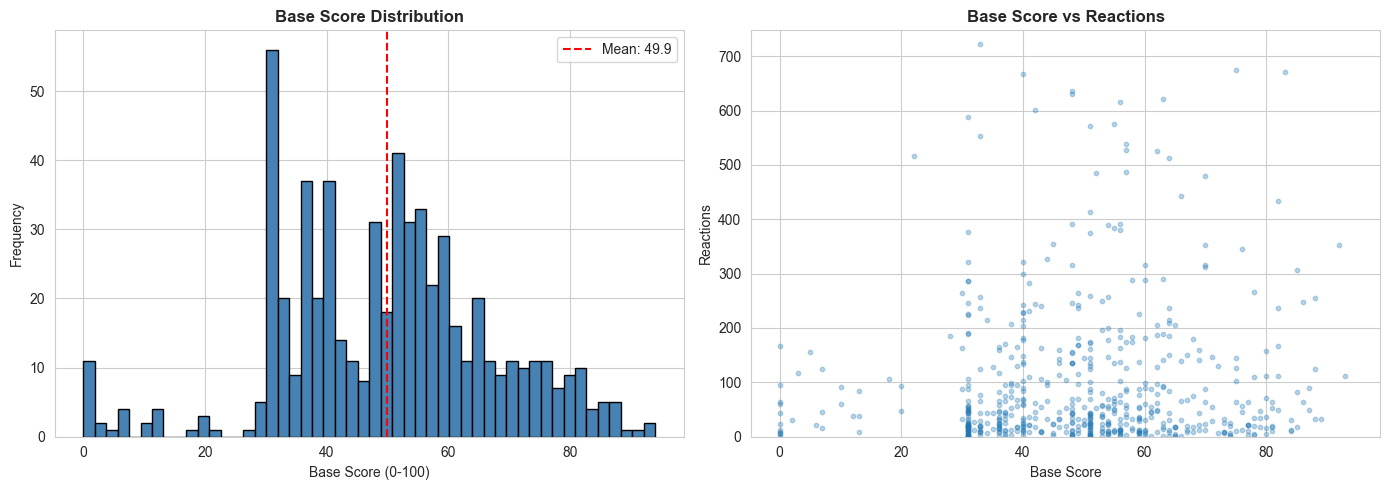


Base score correlation with reactions: 0.070
Base score correlation with comments: 0.092


In [65]:
# Calculate total base score
df['base_score'] = (
    50 +  # Starting point
    df['length_score'] +
    df['hook_score'] +
    df['power_pattern_score'] +
    df['media_score'] +
    df['link_penalty_score'] +
    df['pattern_density_score'] +
    df['promotional_penalty'] +
    df['low_effort_link_penalty'] +
    df['link_spam_penalty']
)

# Cap between 0-100
df['base_score_capped'] = df['base_score'].clip(0, 100)

print("✓ Base score calculated")
print(f"\nBase score statistics:")
print(df['base_score_capped'].describe())

# Visualize base score distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(df['base_score_capped'], bins=50, color='steelblue', edgecolor='black')
axes[0].set_title('Base Score Distribution', fontweight='bold')
axes[0].set_xlabel('Base Score (0-100)')
axes[0].set_ylabel('Frequency')
axes[0].axvline(df['base_score_capped'].mean(), color='red', linestyle='--', label=f'Mean: {df["base_score_capped"].mean():.1f}')
axes[0].legend()

# Base score vs reactions
axes[1].scatter(df['base_score_capped'], df['reactions'], alpha=0.3, s=10)
axes[1].set_title('Base Score vs Reactions', fontweight='bold')
axes[1].set_xlabel('Base Score')
axes[1].set_ylabel('Reactions')
axes[1].set_ylim(0, df['reactions'].quantile(0.95))  # Zoom to 95th percentile

plt.tight_layout()
plt.show()

# Correlation with targets
print(f"\nBase score correlation with reactions: {df['base_score_capped'].corr(df['reactions']):.3f}")
print(f"Base score correlation with comments: {df['base_score_capped'].corr(df['comments']):.3f}")

## 5. Save Progress

Save intermediate results before continuing with NLP features (which are computationally expensive).

In [66]:
# Save progress
CHECKPOINT_FILE = '../data/features_checkpoint_base_formula.csv'
df.to_csv(CHECKPOINT_FILE, index=False)

print(f"✓ Checkpoint saved: {CHECKPOINT_FILE}")
print(f"  Rows: {len(df):,}")
print(f"  Columns: {len(df.columns)}")
print(f"  Features added so far: {len(df.columns) - 28}")


✓ Checkpoint saved: ../data/features_checkpoint_base_formula.csv
  Rows: 606
  Columns: 78
  Features added so far: 50


## 2. NLP Features (40-50 features)

Extract linguistic and semantic features from the text content:
- **Sentiment Analysis**: VADER sentiment scores (positive, negative, neutral, compound)
- **Named Entity Recognition**: Count entities (person, organization, location, etc.)
- **Readability Metrics**: Flesch-Kincaid Grade, Gunning Fog Index, SMOG, etc.
- **Text Statistics**: Lexical diversity, sentence complexity, word difficulty
- **Stylistic Features**: Question marks, exclamation marks, emojis, capitalization patterns

### 2.1 Sentiment Analysis

Use VADER (Valence Aware Dictionary and sEntiment Reasoner) for social media text sentiment analysis.

In [67]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from tqdm import tqdm
tqdm.pandas()

print("Calculating sentiment scores...")
vader = SentimentIntensityAnalyzer()

# Use 'content' column for sentiment analysis
sentiment_scores = df['content'].progress_apply(lambda x: vader.polarity_scores(x) if pd.notna(x) else {'pos': 0, 'neu': 0, 'neg': 0, 'compound': 0})

df['sentiment_positive'] = sentiment_scores.apply(lambda x: x['pos'])
df['sentiment_neutral'] = sentiment_scores.apply(lambda x: x['neu'])
df['sentiment_negative'] = sentiment_scores.apply(lambda x: x['neg'])
df['sentiment_compound'] = sentiment_scores.apply(lambda x: x['compound'])

# Categorize sentiment
def categorize_sentiment(compound_score):
    if compound_score >= 0.05:
        return 'positive'
    elif compound_score <= -0.05:
        return 'negative'
    else:
        return 'neutral'

df['sentiment_category'] = df['sentiment_compound'].apply(categorize_sentiment)

print("✓ Sentiment features created\n")
print("Sentiment distribution:")
print(df['sentiment_category'].value_counts())
print(f"\nAverage compound sentiment: {df['sentiment_compound'].mean():.3f}")

Calculating sentiment scores...


100%|██████████| 606/606 [00:01<00:00, 384.85it/s]

✓ Sentiment features created

Sentiment distribution:
sentiment_category
positive    551
negative     41
neutral      14
Name: count, dtype: int64

Average compound sentiment: 0.765


### 2.2 Named Entity Recognition (NER)

Extract counts of different entity types using spaCy.

In [68]:
print("Extracting named entities...")

def extract_entities(text):
    """Extract entity counts from text using spaCy NER"""
    if pd.isna(text) or text == '':
        return {'PERSON': 0, 'ORG': 0, 'GPE': 0, 'DATE': 0, 'MONEY': 0, 
                'PRODUCT': 0, 'EVENT': 0, 'total_entities': 0}
    
    doc = nlp(text[:1000000])  # Limit text length to avoid processing issues
    
    entity_counts = {
        'PERSON': 0,  # People, including fictional
        'ORG': 0,     # Companies, agencies, institutions
        'GPE': 0,     # Countries, cities, states
        'DATE': 0,    # Absolute or relative dates or periods
        'MONEY': 0,   # Monetary values
        'PRODUCT': 0, # Objects, vehicles, foods, etc.
        'EVENT': 0,   # Named hurricanes, battles, wars, sports events, etc.
    }
    
    for ent in doc.ents:
        if ent.label_ in entity_counts:
            entity_counts[ent.label_] += 1
    
    entity_counts['total_entities'] = sum(entity_counts.values())
    return entity_counts

# Apply NER with progress tracking
entity_results = df['content'].progress_apply(extract_entities)

# Extract individual entity counts
df['ner_person_count'] = entity_results.apply(lambda x: x['PERSON'])
df['ner_org_count'] = entity_results.apply(lambda x: x['ORG'])
df['ner_location_count'] = entity_results.apply(lambda x: x['GPE'])
df['ner_date_count'] = entity_results.apply(lambda x: x['DATE'])
df['ner_money_count'] = entity_results.apply(lambda x: x['MONEY'])
df['ner_product_count'] = entity_results.apply(lambda x: x['PRODUCT'])
df['ner_event_count'] = entity_results.apply(lambda x: x['EVENT'])
df['ner_total_entities'] = entity_results.apply(lambda x: x['total_entities'])

# Binary features
df['has_person_mention'] = (df['ner_person_count'] > 0).astype(int)
df['has_org_mention'] = (df['ner_org_count'] > 0).astype(int)
df['has_location_mention'] = (df['ner_location_count'] > 0).astype(int)
df['has_entities'] = (df['ner_total_entities'] > 0).astype(int)

print("✓ NER features created\n")
print(f"Posts with entities: {df['has_entities'].sum()} ({df['has_entities'].mean()*100:.1f}%)")
print(f"Average entities per post: {df['ner_total_entities'].mean():.2f}")

Extracting named entities...


100%|██████████| 606/606 [00:29<00:00, 20.52it/s]

✓ NER features created

Posts with entities: 585 (96.5%)
Average entities per post: 13.36


### 2.3 Readability Metrics

Calculate various readability scores using textstat library.

In [69]:
import textstat

print("Calculating readability metrics...")

def calculate_readability(text):
    """Calculate various readability scores"""
    if pd.isna(text) or text.strip() == '':
        return {
            'flesch_reading_ease': 0,
            'flesch_kincaid_grade': 0,
            'smog_index': 0,
            'gunning_fog': 0,
            'automated_readability_index': 0
        }
    
    return {
        'flesch_reading_ease': textstat.flesch_reading_ease(text),
        'flesch_kincaid_grade': textstat.flesch_kincaid_grade(text),
        'smog_index': textstat.smog_index(text),
        'gunning_fog': textstat.gunning_fog(text),
        'automated_readability_index': textstat.automated_readability_index(text)
    }

readability_scores = df['content'].progress_apply(calculate_readability)

df['readability_flesch_ease'] = readability_scores.apply(lambda x: x['flesch_reading_ease'])
df['readability_flesch_kincaid'] = readability_scores.apply(lambda x: x['flesch_kincaid_grade'])
df['readability_smog'] = readability_scores.apply(lambda x: x['smog_index'])
df['readability_gunning_fog'] = readability_scores.apply(lambda x: x['gunning_fog'])
df['readability_ari'] = readability_scores.apply(lambda x: x['automated_readability_index'])

print("✓ Readability features created\n")
print("Average readability scores:")
print(f"  Flesch Reading Ease: {df['readability_flesch_ease'].mean():.1f}")
print(f"  Flesch-Kincaid Grade: {df['readability_flesch_kincaid'].mean():.1f}")
print(f"  SMOG Index: {df['readability_smog'].mean():.1f}")
print(f"  Gunning Fog: {df['readability_gunning_fog'].mean():.1f}")
print(f"  Automated Readability Index: {df['readability_ari'].mean():.1f}")

Calculating readability metrics...


100%|██████████| 606/606 [00:00<00:00, 943.90it/s] 

✓ Readability features created

Average readability scores:
  Flesch Reading Ease: 49.3
  Flesch-Kincaid Grade: 10.4
  SMOG Index: 12.2
  Gunning Fog: 12.7
  Automated Readability Index: 11.6


### 2.4 Text Statistics

Calculate lexical diversity, sentence complexity, and other text statistics.

In [70]:
print("Calculating text statistics...")

def calculate_text_stats(text):
    """Calculate various text statistics"""
    if pd.isna(text) or text.strip() == '':
        return {
            'sentence_count': 0,
            'avg_sentence_length': 0,
            'lexical_diversity': 0,
            'syllable_count': 0,
            'avg_syllables_per_word': 0,
            'difficult_words': 0,
            'word_count': 0
        }
    
    # Sentence count
    sentence_count = textstat.sentence_count(text)
    
    # Word and syllable counts
    word_count = textstat.lexicon_count(text, removepunct=True)
    syllable_count = textstat.syllable_count(text)
    
    # Lexical diversity (unique words / total words)
    words = text.lower().split()
    lexical_diversity = len(set(words)) / len(words) if len(words) > 0 else 0
    
    return {
        'sentence_count': sentence_count,
        'avg_sentence_length': word_count / sentence_count if sentence_count > 0 else 0,
        'lexical_diversity': lexical_diversity,
        'syllable_count': syllable_count,
        'avg_syllables_per_word': syllable_count / word_count if word_count > 0 else 0,
        'difficult_words': textstat.difficult_words(text),
        'word_count': word_count
    }

text_stats = df['content'].progress_apply(calculate_text_stats)

df['text_sentence_count'] = text_stats.apply(lambda x: x['sentence_count'])
df['text_avg_sentence_length'] = text_stats.apply(lambda x: x['avg_sentence_length'])
df['text_lexical_diversity'] = text_stats.apply(lambda x: x['lexical_diversity'])
df['text_syllable_count'] = text_stats.apply(lambda x: x['syllable_count'])
df['text_avg_syllables_per_word'] = text_stats.apply(lambda x: x['avg_syllables_per_word'])
df['text_difficult_words_count'] = text_stats.apply(lambda x: x['difficult_words'])
df['text_word_count'] = text_stats.apply(lambda x: x['word_count'])
df['text_difficult_words_ratio'] = df['text_difficult_words_count'] / df['text_word_count'].replace(0, 1)

print("✓ Text statistics features created\n")
print(f"Average sentence count: {df['text_sentence_count'].mean():.1f}")
print(f"Average sentence length: {df['text_avg_sentence_length'].mean():.1f} words")
print(f"Average lexical diversity: {df['text_lexical_diversity'].mean():.3f}")
print(f"Average syllables per word: {df['text_avg_syllables_per_word'].mean():.2f}")

Calculating text statistics...


100%|██████████| 606/606 [00:00<00:00, 1616.01it/s]

✓ Text statistics features created

Average sentence count: 17.9
Average sentence length: 16.1 words
Average lexical diversity: 0.734
Average syllables per word: 1.67


### 2.5 Stylistic Features

Detect stylistic patterns like questions, exclamations, emojis, and capitalization.

In [71]:
print("Extracting stylistic features...")

# Question marks
df['style_question_marks'] = df['content'].str.count(r'\?')
df['style_has_question'] = (df['style_question_marks'] > 0).astype(int)

# Exclamation marks
df['style_exclamation_marks'] = df['content'].str.count(r'!')
df['style_has_exclamation'] = (df['style_exclamation_marks'] > 0).astype(int)

# Emoji detection (simplified - looks for common emoji unicode ranges)
emoji_pattern = r'[\U0001F600-\U0001F64F\U0001F300-\U0001F5FF\U0001F680-\U0001F6FF\U0001F1E0-\U0001F1FF\U00002702-\U000027B0\U000024C2-\U0001F251]+'
df['style_emoji_count'] = df['content'].str.count(emoji_pattern)
df['style_has_emoji'] = (df['style_emoji_count'] > 0).astype(int)

# ALL CAPS words (3+ character words that are all uppercase)
df['style_all_caps_words'] = df['content'].str.findall(r'\b[A-Z]{3,}\b').str.len()
df['style_has_all_caps'] = (df['style_all_caps_words'] > 0).astype(int)

# Quotes (both single and double)
df['style_quote_marks'] = df['content'].str.count(r'["\']')
df['style_has_quotes'] = (df['style_quote_marks'] >= 2).astype(int)  # At least a pair

# Parentheses
df['style_parentheses_count'] = df['content'].str.count(r'[()]')
df['style_has_parentheses'] = (df['style_parentheses_count'] >= 2).astype(int)

# Numbers
df['style_number_count'] = df['content'].str.findall(r'\d+').str.len()
df['style_has_numbers'] = (df['style_number_count'] > 0).astype(int)

# Bullet points or list markers
df['style_bullet_count'] = df['content'].str.findall(r'[•●○▪▫■□★☆→➤✓✔]').str.len()
df['style_has_bullets'] = (df['style_bullet_count'] > 0).astype(int)

print("✓ Stylistic features created\n")
print(f"Posts with questions: {df['style_has_question'].sum()} ({df['style_has_question'].mean()*100:.1f}%)")
print(f"Posts with exclamations: {df['style_has_exclamation'].sum()} ({df['style_has_exclamation'].mean()*100:.1f}%)")
print(f"Posts with emojis: {df['style_has_emoji'].sum()} ({df['style_has_emoji'].mean()*100:.1f}%)")
print(f"Posts with ALL CAPS: {df['style_has_all_caps'].sum()} ({df['style_has_all_caps'].mean()*100:.1f}%)")
print(f"Posts with quotes: {df['style_has_quotes'].sum()} ({df['style_has_quotes'].mean()*100:.1f}%)")

Extracting stylistic features...
✓ Stylistic features created

Posts with questions: 213 (35.1%)
Posts with exclamations: 224 (37.0%)
Posts with emojis: 222 (36.6%)
Posts with ALL CAPS: 368 (60.7%)
Posts with quotes: 209 (34.5%)


### 2.6 Save NLP Checkpoint

In [72]:
# Save progress after NLP features
checkpoint_file = '../data/features_checkpoint_with_nlp.csv'
df.to_csv(checkpoint_file, index=False)
print(f"✓ Checkpoint saved: {checkpoint_file}")
print(f"  Rows: {len(df):,}")
print(f"  Columns: {len(df.columns)}")
print(f"  Features added so far: {len(df.columns) - 29}")

✓ Checkpoint saved: ../data/features_checkpoint_with_nlp.csv
  Rows: 606
  Columns: 124
  Features added so far: 95


## 3. Topic Features (5-10 features)

Add topic modeling labels from previous EDA work.

In [73]:
print("Creating topic features...")

# For now, create placeholder topic features based on content analysis
# In a complete implementation, these would come from LDA or other topic modeling

# Industry-related topics (simplified keyword-based approach)
topics = {
    'tech': ['technology', 'ai', 'software', 'data', 'digital', 'tech', 'innovation', 'machine learning'],
    'business': ['business', 'marketing', 'sales', 'strategy', 'growth', 'entrepreneur', 'startup'],
    'career': ['career', 'job', 'hiring', 'resume', 'interview', 'professional', 'workplace'],
    'leadership': ['leadership', 'management', 'team', 'leader', 'ceo', 'executive'],
    'personal_dev': ['learning', 'skills', 'development', 'education', 'training', 'course'],
    'finance': ['finance', 'investment', 'money', 'funding', 'financial', 'revenue']
}

for topic_name, keywords in topics.items():
    pattern = '|'.join([fr'\b{kw}\b' for kw in keywords])
    df[f'topic_{topic_name}'] = df['clean_content'].str.contains(pattern, case=False, regex=True, na=False).astype(int)

# Count how many topics each post touches
topic_cols = [col for col in df.columns if col.startswith('topic_')]
df['topic_count'] = df[topic_cols].sum(axis=1)
df['is_multi_topic'] = (df['topic_count'] > 1).astype(int)

print("✓ Topic features created\n")
print("Topic distribution:")
for col in topic_cols:
    count = df[col].sum()
    pct = count / len(df) * 100
    print(f"  {col}: {count} ({pct:.1f}%)")
print(f"\nMulti-topic posts: {df['is_multi_topic'].sum()} ({df['is_multi_topic'].mean()*100:.1f}%)")

Creating topic features...
✓ Topic features created

Topic distribution:
  topic_tech: 364 (60.1%)
  topic_business: 199 (32.8%)
  topic_career: 122 (20.1%)
  topic_leadership: 206 (34.0%)
  topic_personal_dev: 186 (30.7%)
  topic_finance: 87 (14.4%)

Multi-topic posts: 339 (55.9%)


## 4. Derived Features (10-20 features)

Create interaction terms, aggregated statistics, and other derived features.

### 4.1 Influencer-Level Aggregations

Calculate statistics about the influencer's posting history.

In [74]:
print("Creating influencer-level features...")

# Calculate influencer-level statistics
influencer_stats = df.groupby('name').agg(
    influencer_avg_reactions=('reactions', 'mean'),
    influencer_std_reactions=('reactions', 'std'),
    influencer_median_reactions=('reactions', 'median'),
    influencer_avg_comments=('comments', 'mean'),
    influencer_std_comments=('comments', 'std'),
    influencer_median_comments=('comments', 'median'),
    influencer_avg_base_score=('base_score_capped', 'mean'),
    influencer_avg_sentiment=('sentiment_compound', 'mean'),
    influencer_post_count=('reactions', 'count')  # post count
).reset_index()

# Calculate total engagement statistics
influencer_engagement = df.groupby('name').agg(
    reactions_sum=('reactions', 'sum'),
    comments_sum=('comments', 'sum')
).reset_index()
influencer_engagement['influencer_total_engagement'] = influencer_engagement['reactions_sum'] + influencer_engagement['comments_sum']
influencer_engagement = influencer_engagement[['name', 'influencer_total_engagement']]

# Merge all influencer stats
influencer_stats = influencer_stats.merge(influencer_engagement, on='name', how='left')
influencer_stats['influencer_avg_engagement'] = influencer_stats['influencer_total_engagement'] / influencer_stats['influencer_post_count']

# Merge back to main dataframe
df = df.merge(influencer_stats, on='name', how='left')

# Handle NaN values in std (occurs when influencer has only 1 post)
df['influencer_std_reactions'] = df['influencer_std_reactions'].fillna(0)
df['influencer_std_comments'] = df['influencer_std_comments'].fillna(0)

# Influencer engagement consistency (coefficient of variation)
df['influencer_consistency_reactions'] = np.where(
    df['influencer_avg_reactions'] > 0,
    df['influencer_std_reactions'] / df['influencer_avg_reactions'],
    0
)

print("✓ Influencer-level features created\n")
print(f"Unique influencers: {df['name'].nunique()}")
print(f"Average posts per influencer: {df['influencer_post_count'].mean():.1f}")
print(f"Average influencer engagement: {df['influencer_avg_engagement'].mean():.1f}")


Creating influencer-level features...
✓ Influencer-level features created

Unique influencers: 420
Average posts per influencer: 3.2
Average influencer engagement: 174.7


### 4.2 Engagement Ratios and Interaction Terms

Create ratio features and interaction terms between existing features.

In [75]:
print("Creating derived engagement features...")

# Comment-to-reaction ratio
df['comment_to_reaction_ratio'] = np.where(
    df['reactions'] > 0,
    df['comments'] / df['reactions'],
    0
)

# Performance relative to influencer average
df['reactions_vs_influencer_avg'] = df['reactions'] / df['influencer_avg_reactions'].replace(0, 1)
df['comments_vs_influencer_avg'] = df['comments'] / df['influencer_avg_comments'].replace(0, 1)

# Engagement per word (efficiency)
df['reactions_per_word'] = df['reactions'] / df['text_word_count'].replace(0, 1)
df['comments_per_word'] = df['comments'] / df['text_word_count'].replace(0, 1)

# Engagement per sentiment score
df['reactions_per_sentiment'] = np.where(
    df['sentiment_compound'] > 0,
    df['reactions'] / df['sentiment_compound'],
    df['reactions']
)

# Interaction: Media × Length category
df['media_x_optimal_length'] = df['has_media'] * (df['length_category'] == 'optimal').astype(int)
df['video_x_optimal_length'] = df['has_video'] * (df['length_category'] == 'optimal').astype(int)

# Interaction: Hook × Power patterns
df['hook_x_power_score'] = df['hook_score'] * df['power_pattern_score']

# Interaction: Sentiment × Readability
df['sentiment_x_readability'] = df['sentiment_compound'] * df['readability_flesch_ease']

# Feature density (how many features per word)
feature_count = (
    df['hook_score'] + 
    df['power_pattern_count'] + 
    df['has_media'] + 
    df['ner_total_entities'] +
    df['style_has_question'] +
    df['style_has_exclamation']
)
df['feature_density'] = feature_count / df['text_word_count'].replace(0, 1)

print("✓ Derived engagement features created\n")
print(f"Average comment-to-reaction ratio: {df['comment_to_reaction_ratio'].mean():.3f}")
print(f"Average reactions per word: {df['reactions_per_word'].mean():.2f}")
print(f"Average feature density: {df['feature_density'].mean():.3f}")

Creating derived engagement features...
✓ Derived engagement features created

Average comment-to-reaction ratio: 0.243
Average reactions per word: 1.64
Average feature density: 0.085


## 5. Feature Summary and Export

Count total features created and save the final dataset.

In [76]:
print("=" * 60)
print("FEATURE ENGINEERING COMPLETE")
print("=" * 60)

# Count features by category
original_cols = 28  # From preprocessed data (slno removed)
total_cols = len(df.columns)
total_features = total_cols - original_cols

# Categorize features
base_formula_features = [col for col in df.columns if any(x in col for x in ['length_', 'hook_', 'power_', 'media_', 'link_', 'pattern_', 'promotional_', 'base_score', 'low_effort', 'link_spam'])]
nlp_features = [col for col in df.columns if any(x in col for x in ['sentiment_', 'ner_', 'readability_', 'text_', 'style_'])]
topic_features = [col for col in df.columns if col.startswith('topic_')]
influencer_features = [col for col in df.columns if col.startswith('influencer_')]
derived_features = [col for col in df.columns if any(x in col for x in ['_ratio', '_vs_', '_per_', '_x_', 'feature_density'])]

print(f"\nDataset Shape: {df.shape[0]:,} rows × {df.shape[1]} columns")
print(f"\nOriginal columns: {original_cols}")
print(f"Total features created: {total_features}")
print(f"\nFeatures by Category:")
print(f"  Base Formula Features: {len(base_formula_features)}")
print(f"  NLP Features: {len(nlp_features)}")
print(f"  Topic Features: {len(topic_features)}")
print(f"  Influencer Features: {len(influencer_features)}")
print(f"  Derived/Interaction Features: {len(derived_features)}")

print(f"\n✓ Goal: 80-100 features")
print(f"✓ Achieved: {total_features} features")

# Feature categories for metadata
feature_metadata = {
    'base_formula_features': base_formula_features,
    'nlp_features': nlp_features,
    'topic_features': topic_features,
    'influencer_features': influencer_features,
    'derived_features': derived_features,
    'total_features': total_features,
    'original_columns': original_cols
}

print(f"\n{'-' * 60}")
print("Sample of created features:")
print(f"{'-' * 60}")
for category, features in [
    ('Base Formula', base_formula_features[:5]),
    ('NLP', nlp_features[:5]),
    ('Topic', topic_features[:3]),
    ('Influencer', influencer_features[:3]),
    ('Derived', derived_features[:3])
]:
    print(f"\n{category}:")
    for feat in features:
        print(f"  - {feat}")


FEATURE ENGINEERING COMPLETE

Dataset Shape: 606 rows × 155 columns

Original columns: 28
Total features created: 127

Features by Category:
  Base Formula Features: 24
  NLP Features: 43
  Topic Features: 7
  Influencer Features: 12
  Derived/Interaction Features: 13

✓ Goal: 80-100 features
✓ Achieved: 127 features

------------------------------------------------------------
Sample of created features:
------------------------------------------------------------

Base Formula:
  - media_type
  - length_score
  - length_category
  - hook_type
  - hook_score

NLP:
  - sentiment_positive
  - sentiment_neutral
  - sentiment_negative
  - sentiment_compound
  - sentiment_category

Topic:
  - topic_tech
  - topic_business
  - topic_career

Influencer:
  - influencer_avg_reactions
  - influencer_std_reactions
  - influencer_median_reactions

Derived:
  - text_avg_syllables_per_word
  - text_difficult_words_ratio
  - comment_to_reaction_ratio


### 5.1 Save Final Dataset

In [77]:
df.columns.tolist()

['name',
 'content',
 'reactions',
 'comments',
 'time_spent',
 'location',
 'followers',
 'media_type',
 'num_hashtags',
 'url_count',
 'has_external_link',
 'urls_list',
 'mention_count',
 'mentions_list',
 'emoji_count',
 'unique_emoji_count',
 'emojis_list',
 'hashtag_count_extracted',
 'hashtags_list',
 'char_count_original',
 'char_count_clean',
 'word_count_original',
 'word_count_clean',
 'sentence_count',
 'question_mark_count',
 'exclamation_mark_count',
 'line_break_count',
 'clean_content',
 'length_score',
 'length_category',
 'first_sentence',
 'hook_type',
 'hook_score',
 'has_never_narrative_hook',
 'has_specific_time_hook',
 'has_quote_hook_hook',
 'has_contrarian_hook',
 'has_belief_transformation_hook',
 'has_announcement_hook',
 'has_everyone_pattern_hook',
 'has_realization_hook',
 'has_recency_hook',
 'has_underdog',
 'has_transformation',
 'has_cta_question',
 'has_hidden_truth',
 'has_vulnerability',
 'has_family',
 'has_specific_time_content',
 'has_specific_nu

In [78]:
# Save the feature-engineered dataset
df.to_csv(OUTPUT_FILE, index=False)
print(f"✓ Feature-engineered dataset saved: {OUTPUT_FILE}")
print(f"  Size: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Save feature metadata
with open(FEATURE_METADATA_FILE, 'w') as f:
    json.dump(feature_metadata, f, indent=2)
print(f"✓ Feature metadata saved: {FEATURE_METADATA_FILE}")

print("\n" + "=" * 60)
print("SUCCESS: Feature engineering pipeline complete!")
print("=" * 60)
print(f"\nNext Steps:")
print(f"  1. Exploratory Feature Analysis (correlation, distributions)")
print(f"  2. Feature Selection (remove redundant/low-importance features)")
print(f"  3. Model Training (XGBoost, Random Forest, Neural Networks)")
print(f"  4. Model Evaluation (MAE, RMSE, R², MAPE)")
print(f"\nOutput Files:")
print(f"  - {OUTPUT_FILE}")
print(f"  - {FEATURE_METADATA_FILE}")
print(f"  - ../data/features_checkpoint_base_formula.csv")
print(f"  - ../data/features_checkpoint_with_nlp.csv")

✓ Feature-engineered dataset saved: ../data/feature_engineered_data.csv
  Size: 4.85 MB
✓ Feature metadata saved: ../data/feature_metadata.json

SUCCESS: Feature engineering pipeline complete!

Next Steps:
  1. Exploratory Feature Analysis (correlation, distributions)
  2. Feature Selection (remove redundant/low-importance features)
  3. Model Training (XGBoost, Random Forest, Neural Networks)
  4. Model Evaluation (MAE, RMSE, R², MAPE)

Output Files:
  - ../data/feature_engineered_data.csv
  - ../data/feature_metadata.json
  - ../data/features_checkpoint_base_formula.csv
  - ../data/features_checkpoint_with_nlp.csv
